# El dataset se puede descargar de: https://www.kaggle.com/datasets/imsparsh/musicnet-dataset

Una vez descargado se debe poner en la carpeta /kaggle/input/musicnet-dataset todo el contenido de la descarga

_______________________________

Para la ejecucipn de este cuaderno se deben instalar las siguientes librerias (en las versiones establecidas), tal como se muestra a continuacion

# 1) Preprocesar datos

In [1]:
import numpy as np

from libraries.Kaggle_audios import Kaggle_audios
from libraries.ProcessAudio import ProcessAudio

In [4]:
TIEMPO_SELECCIONADO = 2
ARCHIVO_FINAL_TRAIN = "data/scaler_pca_to_use/train"
ARCHIVO_FINAL_TEST = "data/scaler_pca_to_use/test"

In [2]:
def prepare_data_tensorflow(data):
    train = data[:, 1:-11]
    instrument_list = data[:,-11:]
    X = np.array(train, dtype=float)
    y = instrument_list
    return X, y

def aplicando_pca(scaler_pca, name_file, dataX, dataY):
    x_for_model = scaler_pca.transform(X=dataX)
    # print("Original", X.shape)
    np.savez_compressed(name_file + ".npz", data=x_for_model)
    np.savez_compressed(name_file + "_label.npz", data=dataY)
    
def leyendo_datos(name_file):
    x = np.load(name_file + ".npz")['data']
    y = np.load(name_file + "_label.npz")['data']
    return x, y

def Preprocesar_audios(name_file, use_train, save:bool = True):
    cortar = Kaggle_audios(config_time=TIEMPO_SELECCIONADO, train=use_train)

    print("\tLeyendo todos los archivos WAV originales")
    all_data, all_label, rate = cortar.read_data(
        limit=None, show_info=False)  # leer todos los wav y cada uno separarlos en pequeños audios de 3 segundos

    print("\tTime:", TIEMPO_SELECCIONADO, " - Input:", all_data.shape, " - Output:", all_label.shape, " - rate:", rate)

    print("\tExtrayendo caracteristicas audios")
    data = list()
    for id_audio, x in enumerate(all_data):
        processAudio = ProcessAudio()
        processAudio.set_data(x)
        data_save = processAudio.get_all(id_audio)  # Extrayendo caracteristicas audios, salen 26 caracteristicas
        data_save += all_label[id_audio].tolist()

        data.append(data_save)
        try:
            if id_audio%150 == 0:
                print("\n\t", end="")
            print(".", end="")
        except:
            print()

    print("\tConvirtiendo a numpy")
    data = np.array(data)

    if save:
        print("\tGuardando data")
        np.savez_compressed(name_file + '.npz', data)
        print("\tGuardando csv completo")

    return data

## 1.1) Leer audios, separarlos en audios mas pequeños y extraer las caracteristicas de cada uno de estos nuevos audios

In [ ]:
print("Preprocesando TRAIN")
data_train = Preprocesar_audios(ARCHIVO_FINAL_TRAIN, use_train=True, save=False)
print("\tTime:", TIEMPO_SELECCIONADO, " - Train:", len(data_train))

## 1.2) Hallando el normalizador y el PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [ ]:
X_train, _ = prepare_data_tensorflow(data_train)
scaler_pca = make_pipeline(StandardScaler(), PCA())
scaler_pca.fit(X_train)

modelo_pca = scaler_pca.named_steps['pca']

In [ ]:
import matplotlib.pyplot as plt
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
ax.plot(
    np.arange(26) + 1,
    prop_varianza_acum,
    marker='o'
)

for x, y in zip(np.arange(26) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x, y),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontsize=20
    )

ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada')

ax.axvline(x=15, color="red")
ax.axhline(y=0.925, color="red")

plt.show()


In [ ]:
"""
            Hallando el Normalizador y el PCA (92%)
"""

MINIMA_VARIANA_EXPLICADA = 0.92
scaler_pca = make_pipeline(StandardScaler(), PCA(MINIMA_VARIANA_EXPLICADA))
scaler_pca.fit(X_train)

In [ ]:
import pickle
pickle.dump(scaler_pca, open('data/scaler_pca_to_use/scaler_pca.pkl','wb'))

## 1.3) Aplicando el normalizador, PCA a los datos train y guardando el resultado

In [ ]:
"""
            Aplicando PCA
"""
X_train, Y_train = prepare_data_tensorflow(data_train)
aplicando_pca(scaler_pca, ARCHIVO_FINAL_TRAIN, X_train, Y_train )

## 1.4) Aplicando el normalizador, PCA a los datos test y guardando el resultado

In [ ]:
print("Preprocesando TEST")
data_test = Preprocesar_audios(ARCHIVO_FINAL_TEST, False, save=False)
print("\tTime:", TIEMPO_SELECCIONADO, " - Test:", len(data_test))

X_test, Y_test = prepare_data_tensorflow(data_test)
aplicando_pca(scaler_pca, ARCHIVO_FINAL_TEST, X_test, Y_test )

# 2) Cargando los datos para usarlos en el entrenamiento del modelo

In [3]:
"""
            Leyendo datos
"""
xTrain_for_model_charge, yTrain = leyendo_datos(ARCHIVO_FINAL_TRAIN)
print("x_for_model_charge_train:", xTrain_for_model_charge.shape, yTrain.shape)

NameError: name 'ARCHIVO_FINAL_TRAIN' is not defined

In [ ]:
xTest_for_model_charge, yTest = leyendo_datos(ARCHIVO_FINAL_TEST)
print("x_for_model_charge_test:", xTest_for_model_charge.shape, yTest.shape)

# 3) Creando y entrenando modelos modelos

## 3.1) Modelo clasico

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics

In [ ]:
mean = lambda lst: int((sum(lst) / len(lst))*100)/100


def calcular_porcentajes_aciertos(y_f, y_t):
    verdaderos = dict()
    falsos = dict()
    for j in range(y_f.shape[1]):
        verdaderos[j] = 0
        falsos[j] = 0

    for i in range(y_f.shape[0]):
        for j in range(y_f.shape[1]):
            if y_f[i][j] == y_t[i][j]:
                verdaderos[j] += 1
            else:
                falsos[j] += 1

    for j in range(y_f.shape[1]):
        #y_final.shape[1] -> 100%
        #verdaderos[j]    -> X
        verdaderos[j] = int(verdaderos[j] * 100 / y_f.shape[0])
        falsos[j] = int(falsos[j] * 100 / y_f.shape[0])

    return verdaderos, falsos, str(mean([v for i, v in verdaderos.items()])) + "%"

## 3.2) Entrenando modelo

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(xTrain_for_model_charge, yTrain, test_size=0.1)  # 0.2

In [ ]:
algoritmo_clasico = RandomForestClassifier()
algoritmo_clasico = MultiOutputClassifier(algoritmo_clasico, n_jobs=-1)

seed = 1
grid = GridSearchCV(
          estimator = algoritmo_clasico,
          param_grid={},
          cv = KFold(n_splits=10, shuffle=True, random_state=seed)
        )
grid.fit(X_train, y_train)
algoritmo_clasico = grid.best_estimator_

## 3.3) Guardando modelo

In [ ]:
pickle.dump(algoritmo_clasico, open('data/scaler_pca_to_use/randomforest.pkl', 'wb'))

## 3.4) Cargando modelo

In [ ]:
model = pickle.load(open('data/scaler_pca_to_use/randomforest.pkl', 'rb'))

## 3.5) Probando modelo

In [ ]:
y_final = model.predict(X_train)

aciertos = calcular_porcentajes_aciertos(y_final, y_train)[2]
print("Aciertos train", aciertos)

## 3.3) Validando modelo

In [ ]:
y_final = model.predict(X_test)

aciertos = calcular_porcentajes_aciertos(y_final, y_test)[2]
print("Aciertos validacion", aciertos)

## 3.4) Testeando modelo

In [ ]:
y_final = model.predict(xTest_for_model_charge)

aciertos = calcular_porcentajes_aciertos(y_final, yTest)[2]
print("Aciertos test", aciertos)

# 4) Creando y entrenando modelo red neuronal

In [10]:
xTrain_for_model_charge, yTrain = leyendo_datos(ARCHIVO_FINAL_TRAIN)
yTrain = np.array(yTrain, dtype=float)
xTrain_for_model_charge = np.array(xTrain_for_model_charge, dtype=float)
print("datos train:", xTrain_for_model_charge.shape, yTrain.shape)

xTest_for_model_charge, yTest = leyendo_datos(ARCHIVO_FINAL_TEST)
yTest = np.array(yTest, dtype=float)
xTest_for_model_charge = np.array(xTest_for_model_charge, dtype=float)
print("datos test:", xTest_for_model_charge.shape, yTest.shape)

datos train: (60851, 15) (60851, 11)
datos test: (745, 15) (745, 11)


In [6]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, LeakyReLU, Conv1D, Conv2D, Flatten, MaxPooling2D, Input
from tensorflow.keras.layers import BatchNormalization, InputLayer, Reshape, Activation, GlobalAveragePooling1D
from tensorflow.keras.layers import AveragePooling2D, AveragePooling1D, UpSampling1D, UpSampling2D, MaxPooling1D

In [7]:
from tensorflow.keras.optimizers import Adam
def get_optimizador():
    adam = Adam(learning_rate=1e-5)
    return adam

In [8]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, RemoteMonitor, TerminateOnNaN, BackupAndRestore

def get_callbacks(name="model"):
    #EarlyStopping, detener el entrenamiento una vez que su pérdida comienza a aumentar
    early_stop = EarlyStopping(
        monitor='accuracy',
        patience=8, #argumento de patience representa el número de épocas antes de detenerse una vez que su pérdida comienza a aumentar (deja de mejorar).
        min_delta=0,  #es un umbral para cuantificar una pérdida en alguna época como mejora o no. Si la diferencia de pérdida es inferior a min_delta , se cuantifica como no mejora. Es mejor dejarlo como 0 ya que estamos interesados ​​en cuando la pérdida empeora.
        restore_best_weights=True,
        mode='max')

    #ReduceLROnPlateau, que si el entrenamiento no mejora tras unos epochs específicos, reduce el valor de learning rate del modelo
    reduce_lr = ReduceLROnPlateau(
        monitor='loss', 
        factor=0.1, 
        patience=5, 
        min_delta=1e-4, 
        mode='min',
        verbose=1,
    )

    # Saves Keras model after each epoch
    #Para algunos casos es importante saber cual entrenamiento fue mejor, 
    #este callback guarda el modelo tras cada epoca completada con el fin de si luego se desea un registro de pesos para cada epoca
    #Se ha usado este callback para poder optener el mejor modelo de pesos, sobretodo en la red neuronal creada desde cero
    #siendo de gran utilidad para determinar el como ir modificando los layer hasta obtener el mejor modelo
    checkpointer = ModelCheckpoint(
        filepath='models_backup/' + name +'-{val_accuracy:.4f}.h5', 
        monitor='val_accuracy',
        verbose=1, 
        mode='max',
        save_best_only=True,
        save_weights_only=False
    )

    remote_monitor = RemoteMonitor(
        root='http://localhost:6006',
        path='/publish/epoch/end/',
        field='data',
        headers=None,
        send_as_json=False
    )
    
    backup_restore = BackupAndRestore(backup_dir="backup")
    
    proteccion_nan_loss = TerminateOnNaN()

    
    callbacks_list = [early_stop, reduce_lr, checkpointer, proteccion_nan_loss, backup_restore]#, remote_monitor]
    
    return callbacks_list

In [9]:
import matplotlib.pyplot as plt
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [52]:
cantidad_entradas = 15
cantidad_salidas = 11

model = Sequential(name="RedBasica")
model.add(Dense(32, activation='relu', input_shape=(cantidad_entradas,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(cantidad_salidas, activation='softmax', name='output_layer'))

#model.summary()

In [53]:
model.compile(optimizer=get_optimizador(),
              loss='mse',  # categorical_crossentropy sparse_categorical_crossentropy mean_squared_error
              metrics=['accuracy'])

In [54]:
X_train, X_test, y_train, y_test = train_test_split(xTrain_for_model_charge, yTrain, test_size=0.1)  # 0.2

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=500,
    batch_size=64,
    verbose=1,
    callbacks=get_callbacks()
)

Epoch 1/500
844/856 [============================>.] - ETA: 0s - loss: 0.1343 - accuracy: 0.4639
Epoch 1: val_accuracy improved from -inf to 0.67286, saving model to models_backup/model-0.6729.h5
856/856 [==============================] - 3s 3ms/step - loss: 0.1342 - accuracy: 0.4654 - val_loss: 0.1162 - val_accuracy: 0.6729 - lr: 1.0000e-05
Epoch 2/500
843/856 [============================>.] - ETA: 0s - loss: 0.1095 - accuracy: 0.6472
Epoch 2: val_accuracy improved from 0.67286 to 0.76241, saving model to models_backup/model-0.7624.h5
856/856 [==============================] - 2s 2ms/step - loss: 0.1095 - accuracy: 0.6474 - val_loss: 0.0922 - val_accuracy: 0.7624 - lr: 1.0000e-05
Epoch 3/500
849/856 [============================>.] - ETA: 0s - loss: 0.0979 - accuracy: 0.6964
Epoch 3: val_accuracy improved from 0.76241 to 0.77046, saving model to models_backup/model-0.7705.h5
856/856 [==============================] - 2s 2ms/step - loss: 0.0979 - accuracy: 0.6963 - val_loss: 0.0878 - 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


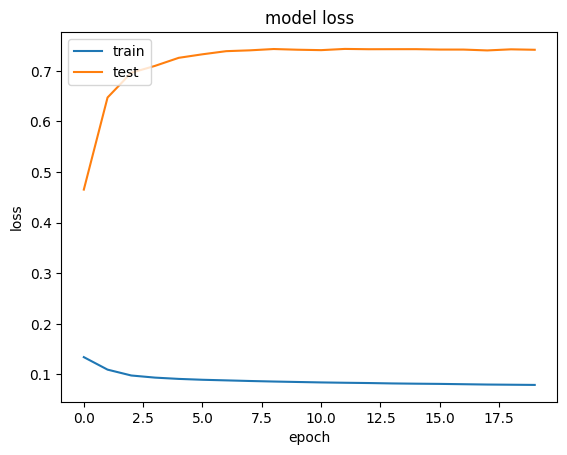

In [57]:
plot_history(history)

In [58]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Evaluate train acc: ', test_acc)

191/191 [==============================] - 0s 1ms/step - loss: 0.0790 - accuracy: 0.8004
Evaluate train acc:  0.8003615140914917


In [41]:
def modelo_simple(cantidad_entradas, cantidad_salidas):
    model = Sequential(name="Redsimple")  # los nombres van sin espacios
    model.add(Dense(8 * 4, activation="relu",  input_shape=(cantidad_entradas,)) ) 
    model.add(Dense(16*4, activation='relu'))
    #model.add(Dense(16*8, activation='relu'))
    #model.add(Dense(32*8, activation='relu'))
    model.add(Reshape((16, 4)))

    model.add(UpSampling1D(size=3))
    model.add(Conv1D(12, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv1D(12, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv1D(12, kernel_size=3, padding="same", activation='relu'))
    model.add(MaxPooling1D(pool_size=3, strides=1, padding='valid'))

    model.add(Conv1D(24, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv1D(24, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv1D(32, kernel_size=3, padding="same", activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=1, padding='valid'))

    model.add(Conv1D(32, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv1D(32, kernel_size=3, padding="same", activation='relu'))
    model.add(MaxPooling1D(pool_size=3, strides=1, padding='valid'))

    model.add(Conv1D(24, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv1D(24, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv1D(16, kernel_size=3, padding="same", activation='relu'))
    model.add(MaxPooling1D(pool_size=3, strides=1, padding='valid'))

    model.add(Conv1D(16, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv1D(8, kernel_size=3, padding="same", activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=1, padding='valid'))

    model.add(Dense(24, activation="relu"))
    model.add(Dense(16, activation="relu"))
    model.add(MaxPooling1D(pool_size=2, strides=1, padding='valid'))

    model.add(Dropout(0.5))

    model.add(Dense(64, activation="relu"))
    model.add(Dense(32, activation='relu'))

    model.add(GlobalAveragePooling1D())

    model.add(Flatten())

    model.add(Dense(cantidad_salidas, activation="softmax", name='output_layer'))

    return model

In [42]:
cantidad_entradas = 15
cantidad_salidas = 11

model = modelo_simple(cantidad_entradas, cantidad_salidas)

model.summary()

Model: "Redsimple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 32)                512       
                                                                 
 dense_50 (Dense)            (None, 64)                2112      
                                                                 
 reshape_9 (Reshape)         (None, 16, 4)             0         
                                                                 
 up_sampling1d_9 (UpSampling  (None, 48, 4)            0         
 1D)                                                             
                                                                 
 conv1d_117 (Conv1D)         (None, 48, 12)            156       
                                                                 
 conv1d_118 (Conv1D)         (None, 48, 12)            444       
                                                         

In [43]:
model.compile(optimizer=get_optimizador(),
              loss='mean_squared_error',  # categorical_crossentropy sparse_categorical_crossentropy mean_squared_error
              metrics=['accuracy'])

In [44]:
X_train, X_test, y_train, y_test = train_test_split(xTrain_for_model_charge, yTrain, test_size=0.1)  # 0.2

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=500,
    batch_size=64,
    verbose=1,
    callbacks=get_callbacks()
)



Epoch 1/500
856/856 [==============================] - ETA: 0s - loss: 0.1365 - accuracy: 0.1662
Epoch 1: val_accuracy improved from -inf to 0.67499, saving model to models_backup/model-0.6750.h5
856/856 [==============================] - 9s 9ms/step - loss: 0.1365 - accuracy: 0.1662 - val_loss: 0.1123 - val_accuracy: 0.6750 - lr: 1.0000e-05
Epoch 2/500
856/856 [==============================] - ETA: 0s - loss: 0.1102 - accuracy: 0.6665
Epoch 2: val_accuracy did not improve from 0.67499
856/856 [==============================] - 7s 8ms/step - loss: 0.1102 - accuracy: 0.6665 - val_loss: 0.1067 - val_accuracy: 0.6750 - lr: 1.0000e-05
Epoch 3/500
852/856 [============================>.] - ETA: 0s - loss: 0.1075 - accuracy: 0.6666
Epoch 3: val_accuracy did not improve from 0.67499
856/856 [==============================] - 7s 8ms/step - loss: 0.1075 - accuracy: 0.6666 - val_loss: 0.1041 - val_accuracy: 0.6750 - lr: 1.0000e-05
Epoch 4/500
850/856 [============================>.] - ETA: 0s -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


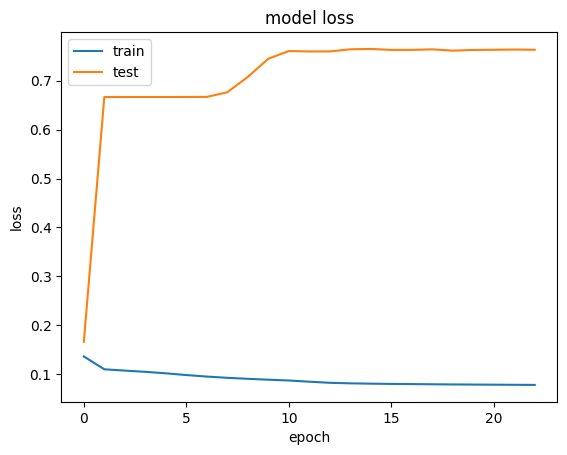

In [45]:
plot_history(history)

In [46]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Evaluate train acc: ', test_acc)

191/191 [==============================] - 1s 3ms/step - loss: 0.0782 - accuracy: 0.7700
Evaluate train acc:  0.7699638605117798


# Bibliografia usada